# load data

In [1]:
pwd

'/gpfs/home/nonnenma/projects/seasonal_forecasting/code/notebooks'

In [2]:
%matplotlib inline
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn

from predictability_utils.utils import helpers, io
from predictability_utils.methods.lrlin_method import run_lrlin
from predictability_utils.methods.cca_method import run_cca

import torch
torch.manual_seed(42)

root_data = '../../data/pyrina'

n_latents = 5
train_months, test_months = [2,3,4], [5,6,7]
y_train = 51

# Volumetric soil water layer 1 (EU) ANOMALIES
source_data, _ = io.data_load('swvl1', 'EU', 'anomalies', root_data)

# Temperature at 2m (EU) ANOMALIES
target_data, _ = io.data_load('t2m', 'EU', 'anomalies', root_data)

# training data time stamps and map shape
nc_fn = root_data + "/t2m_ERA20c_monthly_1900-2010.EU.mv.nc"
ts = Dataset(nc_fn, 'r').variables['time'].__array__().data
t2m_eu = Dataset(nc_fn, 'r').variables['t2m'].__array__().data
map_shape = t2m_eu.shape[1:]

idcs = helpers.split_train_data(ts, y_train, train_months, test_months)
idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs

# let's not miss a year
assert np.prod(idx_source_train.shape) + np.prod(idx_source_test.shape) == len(ts)/12 * len(train_months)
assert np.prod(idx_target_train.shape) + np.prod(idx_target_test.shape) == len(ts)/12 * len(test_months)

swvl1.shape (1332, 37, 42)
t2m.shape (1332, 37, 42)


# recreate CCA analysis
- Canonical correlation analysis to identify subspaces $U$, $V$ in source space $X$ and target space $Y$, respectively, such that $(UX)_i$ and $(VY)_i$ are maximally correlated.
- in a second step, establish a (linear) mapping from $VY \approx Q UX$ to predict $VY$ from $UX$.
- predict new $Y$ from $Y \approx V^\dagger Q UX$

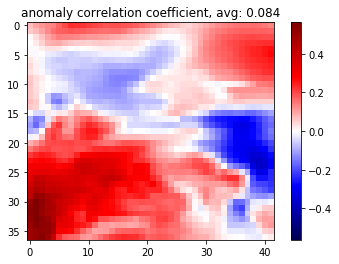

In [3]:
anomaly_corrs, params = run_cca(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape)

# simple low-rank linear prediction (pixel MSEs) 

- set up simple model $Y = W X$ with $W = U V$
- low-rank: if $Y \in \mathbb{R}^N, X \in \mathbb{R}^M$, then $W \in \mathbb{R}^{N \times M}$, but $U \in \mathbb{R}^{N \times k}, V \in \mathbb{R}^{k \times M}$ with $k << M,N$ !
- low-rank structure saves us parameters: $M N$ parameters in $W$, but only $N k + k M$ in $U$ and $V$, helps prevent overfitting on low samples size

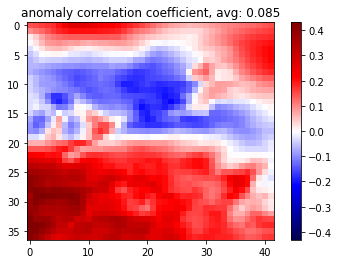

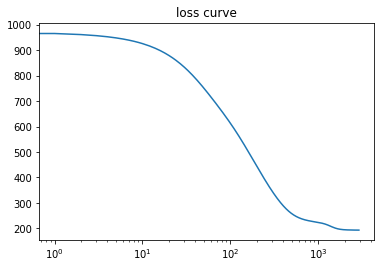

In [4]:
anomaly_corrs, params = run_lrlin(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape)

# debug